# Semi-Supervised Deep Learning

Welcome to the hands-on component of the Semi-Supervised Deep Learning (SSDL) workshop. You should by this stage have a high level understanding of a few semi-supervised techniques for training a deep learning model. The exercises in this notebook are intended to help you solidify your understanding by guiding you through the process of implementing some of the techniques that you have learned.

It is worth noting that these exercises will focus more on the implementation of SSDL and less so on getting the best possible results from a dataset or model architecture. We do not aim to prove that SSDL will be successful on the toy dataset and model architecture we will be using. Instead, we will look at how SSDL can be implemented and applied to deep learning at a broad level.

## Let's start with the data

We will be using the popular [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images across 10 classes, with 6000 images per class. Of these 6000 images per class, 5000 are intended as training images and 10000 reserved for validating your model.

The following code downloads the CIFAR-10 dataset and preprocesses it into a slightly different format for your convenience. Specifically it:

*   Normalises all images pixel values to a range 0 to 1.
*   Removes redundant dimensions of size 1.
*   Splits the training set into 10 lists with each list containing all images for a class.

The final data structure is named "dataset" and is a Python dictionary with the following structure:

```
{
  'train_images' : <contains all 50000 training images>
  'train_labels' : <contains the integer labels for the 50000 training images>
  'train_images_grouped' : <a list of 10 lists, each containing the training images for each class>
  'test_images' : <contains all 10000 test images>
  'test_labels' : <contains the integer labels for the 10000 test images>
}
```

Run the code below to prepare your data.

In [ ]:
# Load the modules we will be using today
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import random
import pickle

# Preprocess the dataset for convenience
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Normalise the images and remove redundant dimensions
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

# Populate the "dataset" dictionary with the CIFAR-10 data
dataset = {}
dataset['train_images'] = train_images
dataset['train_labels'] = train_labels
dataset['train_images_grouped'] = [ [] for i in range(10) ]
dataset['test_images'] = test_images
dataset['test_labels'] = test_labels

for i in range(train_labels.shape[0]):
  dataset['train_images_grouped'][train_labels[i]].append(train_images[i])


Note that the "dataset" object does not contain "train_labels_grouped" as the index of each list can be used to represent the integer label for that list.

Next, spend some time in the code block below to explore and understand the structure and contents of the dataset you will be working with. This understanding is important for you to complete your model training script in a later stage of this exercise.

Some example code has been provided for your convenience. Can you identify the 10 object classes in this dataset?

In [ ]:
### Inspect the dataset ###
print('Dataset keys:', [k for k in dataset.keys()])
print('Training images per class:', [len(c) for c in dataset['train_images_grouped']])
print('Image shape:', dataset['train_images_grouped'][0][0].shape)

fig=plt.figure(figsize=(20, 20))
rows = 10 # Show all 10 classes
columns = 5 # Show 5 samples per class
for i in range(rows):
  for j in range(columns):
    fig.add_subplot(rows, columns, (i)*columns+j+1)
    plt.imshow(dataset['train_images_grouped'][i][j])
plt.show()



## Partially labelled data

You would be aware that all images in your dataset have been provided a corresponding label. If you were to train a model with all the data as is, you would have a fully supervised model. 

In the spirit of semi-supervised learning, we will need to simulate the lack of labelled data. One simply way to do so is to extract a small subset of the images and their corresponding labels; you may then pretend that everything else does not have a label.

The code below extracts this "supervised" data subset. Note that all object classes have an equal number of extracted samples. It is suggested that you start with extracting only 1% of the dataset so that testing and debugging of your subsequent code runs quicker. You may certainly increase this portion at a later stage.

In [ ]:
# Extract the first 1% of labelled samples
take_first_X = 50
train_images_supervised = []; train_labels_supervised = []
for i in range(10):
    train_images_supervised += dataset['train_images_grouped'][i][:take_first_X]
    train_labels_supervised += [i] * take_first_X

train_images_supervised = np.asarray(train_images_supervised)
train_labels_supervised = np.asarray(train_labels_supervised, np.int32)





## Defining the model architecture

Now that we have our data ready, let's turn our attention to the model architecture. Remember that our aim is not to get the best possible performance out of the data we have, but to focus on learning how to implement SSDL techniques. With that in mind, we will be looking at simple toy models that we would be able to build from the ground up.

You would be familiar with various SSDL techniques by now. One commonality among many of these techniques is a neural network that has two "heads" that can be trained on two different tasks.


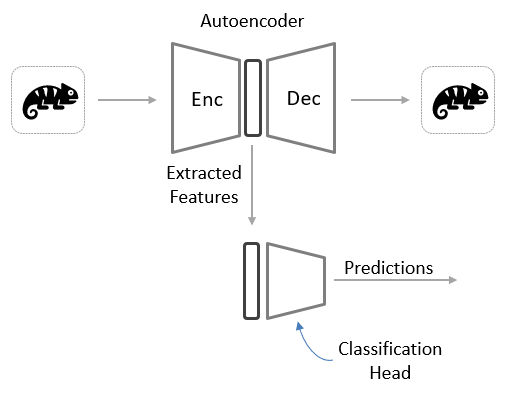

The diagram above is an example of a model with two "heads", one a decoder that regenerates the original image as part of an autoencoder used in the unsupervised learning stage, the other a classification head that learns to classify images based on supervised (labelled) data. We will be using this model architecture as our base model in this exercise. 

The following section invites you to complete the code for such a model using TensorFlow. There is no need for you to construct a deep, complex model; just 2-3 layers in each of the encoder, decoder and classification modules are sufficient for the purpose of this exercise. You may wish to use the following neural network layers to construct your model:

*   [keras.layers.Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)
*   [keras.layers.Dense](https://keras.io/api/layers/core_layers/dense/)
*   [keras.layers.Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)



In [ ]:
### Define the model architecture ###
class SimpleModel(tf.keras.Model):
  def __init__(self):
    super(SimpleModel, self).__init__()

    # The init function runs once when the model is created.
    # This is where you should initialise the weights/layers of your network. 
    # Some layers have been created for you. You may add more layers if you wish or stick to what is already provided.

    ### Encoder layers ###
    self.enConv1 = L.Conv2D(16,(3,3), padding='same', activation='relu')
    self.enConv2 = L.Conv2D(32,(3,3), padding='same', activation='relu')
    self.enConv3 = L.Conv2D(64,(3,3), padding='same', activation='relu')

    ### Classification head layers ###
    self.dense1 = L.Dense(32, activation='relu')
    self.dense2 = L.Dense(10, activation=None)

    ### Decoder head layers ###
    # Creating an output the same shape as the input using deconvolution layers may be tricky.
    # Using padding='same' makes it easier.
    self.deConv1 = L.Conv2DTranspose(32, (3,3), padding='same', strides=(2,2), activation='relu')
    self.deConv2 = L.Conv2DTranspose(1, (3,3), padding='same', strides=(2,2), activation='sigmoid')
    

  def call(self, x):
    # The call function runs each time you invoke the model during training or inference.
    # This is where you should define the flow of information through your model.

    # TODO: Build your model data flow graph here by invoking the layers you created above.

    # Encoder - the first two lines have been filled in for you below. Complete the rest of the encoder.
    x = self.enConv1(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Classification head
    # Hint: Flatten the output of your encoder then pass them into the dense classification layers.
    

    # Decoder head
    # Hint: Pass the output of your encoder into the deconvolution layers here
    

    # Don't forget to return the output-pointers of your model (classification and decoder heads)
    return 

## Testing data flow through the model

We should test the construction of our model as good practice before moving on to the next task. Create an instance of the model in the code block below and pass randomly generated data through it. While this does not verify the learning abilities of the model, it does at least allow us to confirm that data is able to flow through the model without errors.

Fix any errors that arise.

In [ ]:
# TODO: Create an instance of the model and pass randomly generated data through it.




## Defining the loss function

Since our model has two heads, our loss function would consist of two components - a separate loss for each of the heads. There are two ways in which we could utilise the loss for each of the two heads: 

1. We could utilise each loss separately across two distinct training stages (e.g. unsupervised learning using the decoder head followed by supervised training using the classification head).
2. We could combine the losses and perform unsupervised and supervised learning simultaneously.

We will be taking the latter approach in this exercise.

For simplicity's sake, we will use a [standard cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits) for the classification head, and a standard mean-squared-error (L2 loss) for the autoencoder. 

Write your loss function in the code block below. The function should have two modes (supervised and unsupervised training) controlled by an IF-statement. 

    if mode=='supervised':
      ...
    elif mode=='unsupervised':
      ...

Since the model has access to labels in the supervised mode, the final loss would just be a linear combination of the classification loss and the autoencoder's reconstruction loss. On the other hand, the unsupervised mode would have a loss function with the classification loss being a constant zero.

In [ ]:
### Define the loss function ###

def SemiSupervised_CrossEntropy_or_MSE(labels, inputs, logits, regen_img, mode='supervised'):

  # TODO: Write the code for your loss function here. 
  # labels: the labels for the supervised portion of data.
  # inputs: the training images (labels for the unsupervised portion of data).
  # logits: raw output of your classification head.
  # regen_img: the output of your decoder head (the regenerated image).
  # mode: Your loss function should have a supervised mode and an unsupervised mode.

  if mode == 'supervised':
    # Calculate the loss for a supervised batch here.
    classification_loss = #TODO

    reconstruction_loss = #TODO

    return classification_loss + reconstruction_loss

  else:
    # Calculate the loss for an unsupervised batch here.
    classification_loss = #TODO

    reconstruction_loss = #TODO

    return classification_loss + reconstruction_loss



## Defining the validation function

Finally, before we proceed onto the main training script, we should define a validation function. The validation function has been completed for you below to ensure standardisation in testing procedure across all students completing this exercise. This is to facilitate consistent comparison of results and discussion between students.

The validation function receives as input a pointer to your trained model and the entire test set, including both images and labels. The test set can be retrieved directly from your prepared dataset object. The function then prints onto screen the validation accuracy and a 10x10 confusion matrix where the rows represent the labels and the columns represent the model predictions.

In [ ]:
### Define a validation function ###
def ValidateModel(model, test_images, test_labels):
  predictions, seg = model.predict(test_images)
  predicted_classes = np.argmax(predictions, axis=-1)
  accuracy = 1. * np.sum(predicted_classes == test_labels) / test_labels.shape[0]
  print('Validation accuracy =', accuracy)
  confusion_matrix = np.zeros((10,10))
  for i in range(test_labels.shape[0]):
    confusion_matrix[test_labels[i],predicted_classes[i]] += 1
  print(confusion_matrix)

## Training the model

Finally, it's model training time!

The code below is a skeleton training script that you should modify to your own needs. Your first task is to validate all the code you have prepared so far by training a model and demonstrating that it is able to learn (reduce it's loss) from both supervised and unsupervised data.

Once you have performed this first step, proceed to complete as many of the exercises below which look at evaluating various SSDL training strategies.


In [ ]:
### The main training script ###

# Create an instance of your model and define an optimiser
model = SimpleModel()
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Main training and validation loop
max_train_batches = 3000
batch_size = 32
train_batch = 0
while train_batch < max_train_batches:
    train_batch += 1

    # Design a decision process to determine if you should use a supervised or unsupervised batch in this iteration
    # A random number generator is a good start


    if ... : # if supervised
      # Randomly sample a supervised batch from your extracted supervised dataset
      input_batch = []; label_batch = []
      for i in range(batch_size):
        x = np.random.randint(0, train_images_supervised.shape[0])
        input_batch.append(train_images_supervised[x])
        label_batch.append(train_labels_supervised[x])
        
    else: # if unsupervised
      # Randomly sample an unsupervised batch from the full train set
      input_batch = []
      for i in range(batch_size):
        x = np.random.randint(0, dataset['train_images'].shape[0])
        input_batch.append(dataset['train_images'][x])

    with tf.GradientTape() as tape:
      # Infer a batch through the model
      input_batch = np.asarray(input_batch)
      logits, regen_img = model(input_batch, training=True)
      
      # Calculate the loss depending on training mode
      if ... : # Supervised mode
          loss = SemiSupervised_CrossEntropy_or_MSE( ... , mode='supervised')
      else: # Unsupervised mode
          loss = SemiSupervised_CrossEntropy_or_MSE( ... , mode='unsupervised')

      # Perform gradient descent on the loss    
      gradients = tape.gradient(loss, model.trainable_variables)
      optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    # Validation at every certain number of batches
    if train_batch % 250 == 0:
      print('Validation at train batch', train_batch)
      ValidateModel(model, dataset['test_images'], dataset['test_labels'])


## Simple SSDL experiments

Here are some simple experiments that you should be able to try in a short period of time. Don't forget to note down your observations or conclusions for dicussion.

1. Many SSDL techniques utilise unsupervised learning to train the model's feature extractors as a first step, then supervised learning to fine tune the model's classifiers. Modify your batch sampling strategy such that you have a high chance of sampling an unsupervised batch at the start of training, then gradually decrease that probability as you progress through training.

2. You may choose to give the classification and reconstruction (autoencoder) loss different weightings throughout the training process.

3. Remember, if you followed our recommendations, that you are utilising only 1% of all labelled data as your supervised dataset. Try increasing the size of your supervised dataset and observe its effect on training results.

4. We have so far assumed that all object classes have an equal number of labelled data points. What happens if only some classes have labelled data? Try training a model by excluding the labels for the last 3 classes. How does the model perform differently?

5. Implement data augmentation techniques to leverage on the smoothness assumption of SSDL. You may choose to add random noise to your images, stretch, warp, rotate, flip, adjust the brightness and contrast or even discolour them.

6. Self-training: Use your partially trained model to provide predictions on some unlabelled data. Take the most confident predictions and add them as labels to your labelled dataset. Retrain and repeat. Does model performance improve over time?


## Advanced SSDL experiments

Here are some more complex experiments that you may wish to attempt in your free time. You should check that you have all the theoretical knowledge needed to complete these exercises before ending your workshop session. Feel free to bring them up for discussion if you have any queries.

1. Incremental and selective labelling: Infer some unlabelled data through your partially trained model. Provide labels for the least confident predictions. Continue training your model with your expanded dataset. Repeat this process until satisfactory results are achieved.

2. Increase the size and diversity of your unsupervised dataset by incorporating images from other datasets. The additional and novel visual features in the new data may be beneficial for model training.

3. Implement a co-training approach where two or more models are separately trained on different subsets of labelled data. Infer some unlabelled data through the partially trained models. The most confident predictions of one model are then used as labels for the other models.

## The End

Congratulations on reaching the end of this workshop exercise! You would by now have gained hands-on experience in applying semi-supervised deep learning techniques to training a neural network. 

SSDL techniques are wide and varied. Although their use in model training does not guarantee success, the theoretical concepts discussed in this workshop are widely applicable across many areas of deep learning. You would hopefully have a new tool in your arsenal of deep learning know-how to advance your deep learning research.

---
Developed by Titus Tang, 2021







